# 1D Segment Binary Classification

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

import sklearn
from sklearn import datasets
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

import numpy as np
import math
from tqdm import trange

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib.ticker import FormatStrFormatter
import imageio

In [2]:
%matplotlib notebook

# Neural Network w/ 1 Hidden Layer

In [3]:
# define the architecture of the network
class NNClassifier(nn.Module):
    _activation_function = dict(tanh=torch.tanh, relu=torch.relu, sin=torch.sin, sq=torch.mul)
    def __init__(self, input_shape, hidden_shape, activation):
        assert activation in self._activation_function, '{} function not available.'.format(activation)
        super().__init__()
        self._hidden_layer = nn.Linear(in_features=input_shape, out_features=hidden_shape)
        self._output_layer = nn.Linear(in_features=hidden_shape, out_features=1)
        self._hidden_shape = hidden_shape
        self._activation = activation
        
    def hidden_layer(self, X):
        if self._activation == 'sq':
            return self._activation_function[self._activation](self._hidden_layer(X), self._hidden_layer(X))
        return self._activation_function[self._activation](self._hidden_layer(X))
    
    def output_layer(self, X):
        return torch.sigmoid(self._output_layer(X))

    def forward(self, X):
        return self.output_layer(self.hidden_layer(X))
    
    def predict(self, X):
        return self.forward(X).clone().detach()
    
    def train(self, X, y, epochs, optimizer, criterion, plot = False, **kwargs):
        losses = []
        im = []
        im_aux = []
            
        for i in range(epochs):
            y_pred = self.forward(X)
            
            loss = criterion(y_pred[:, 0], y)
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # if the option of plot is true, then a gif is generated with the evolution of the frontier or the hidden space
            if plot and (i + 1) in np.logspace(np.log10(1), np.log10(epochs), num=kwargs['num_plots']).round():
                fig = plt.figure(constrained_layout=True, figsize=(9,5))
                gs = fig.add_gridspec(nrows=1, ncols=3)
                ax0 = fig.add_subplot(gs[0, :-1])
                ax1 = fig.add_subplot(gs[0, -1])
                ax1.plot(losses)
                if kwargs['plot_type'] == 'surface':
                    surface_prediction = self.output_layer(kwargs['points']).detach()
                    ax0.pcolormesh(kwargs['X1'], kwargs['X2'], 
                                  surface_prediction.reshape(kwargs['num_points'], kwargs['num_points']), 
                                  cmap=plt.cm.get_cmap('YlGn'))
                    
                    H = self.hidden_layer(X).detach().numpy()
                    ax0.scatter(H[:, 0], H[:, 1], c=y)
                    ax0.set(title='Hidden Space Frontier')
                    
                else:
                    H = self.hidden_layer(X).detach().numpy()
                    ax0.scatter(H[:, 0], H[:, 1], c=y)
                    ax0.set(title='Hidden Space')
                    
                fig.suptitle('Epoch {}'.format(i))
                image = NNClassifier._aux_plot(fig, ax0, ax1)
                im.append(image)
                im_aux.append(image)
                
        print('Accuracy: {}'.format(accuracy_score(model.predict(X)[:,0].numpy().round(),y.numpy())))
        if plot:
            kwargs_write = {'fps':1.0, 'quantizer':'nq'}
            #imageio.mimsave('{}_init.gif'.format(kwargs['file_name']), im, fps=10)
            imageio.mimsave('{}.gif'.format(kwargs['file_name']), im_aux, fps=10)
        return losses
    
    # auxiliar method for the plot function
    @staticmethod
    def _aux_plot(fig, ax0, ax1):
        ax0.axis('equal')
        ax0.get_xaxis().set_visible(False)
        ax0.get_yaxis().set_visible(False)
        ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        ax1.get_xaxis().set_visible(False)
        ax1.set(title='Loss')
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return image

## Define Dataset

In [4]:
def subsets(m):
    num_points = 30
    a = 0
    width = 2
    for i in range(m):
        if i == 0:
            data = [[np.random.uniform(a, a + width), 0] for i in range(num_points)]
        else:
            if i % 2:
                data.extend([[np.random.uniform(a, a + width), 1] for i in range(num_points)])
            else:
                data.extend([[np.random.uniform(a, a + width), 0] for i in range(num_points)])
        a = a + width + 0.5
    data = np.array(data)
    aux = np.zeros(m * num_points)
    return data, aux


## Injective: tanh

<IPython.core.display.Javascript object>


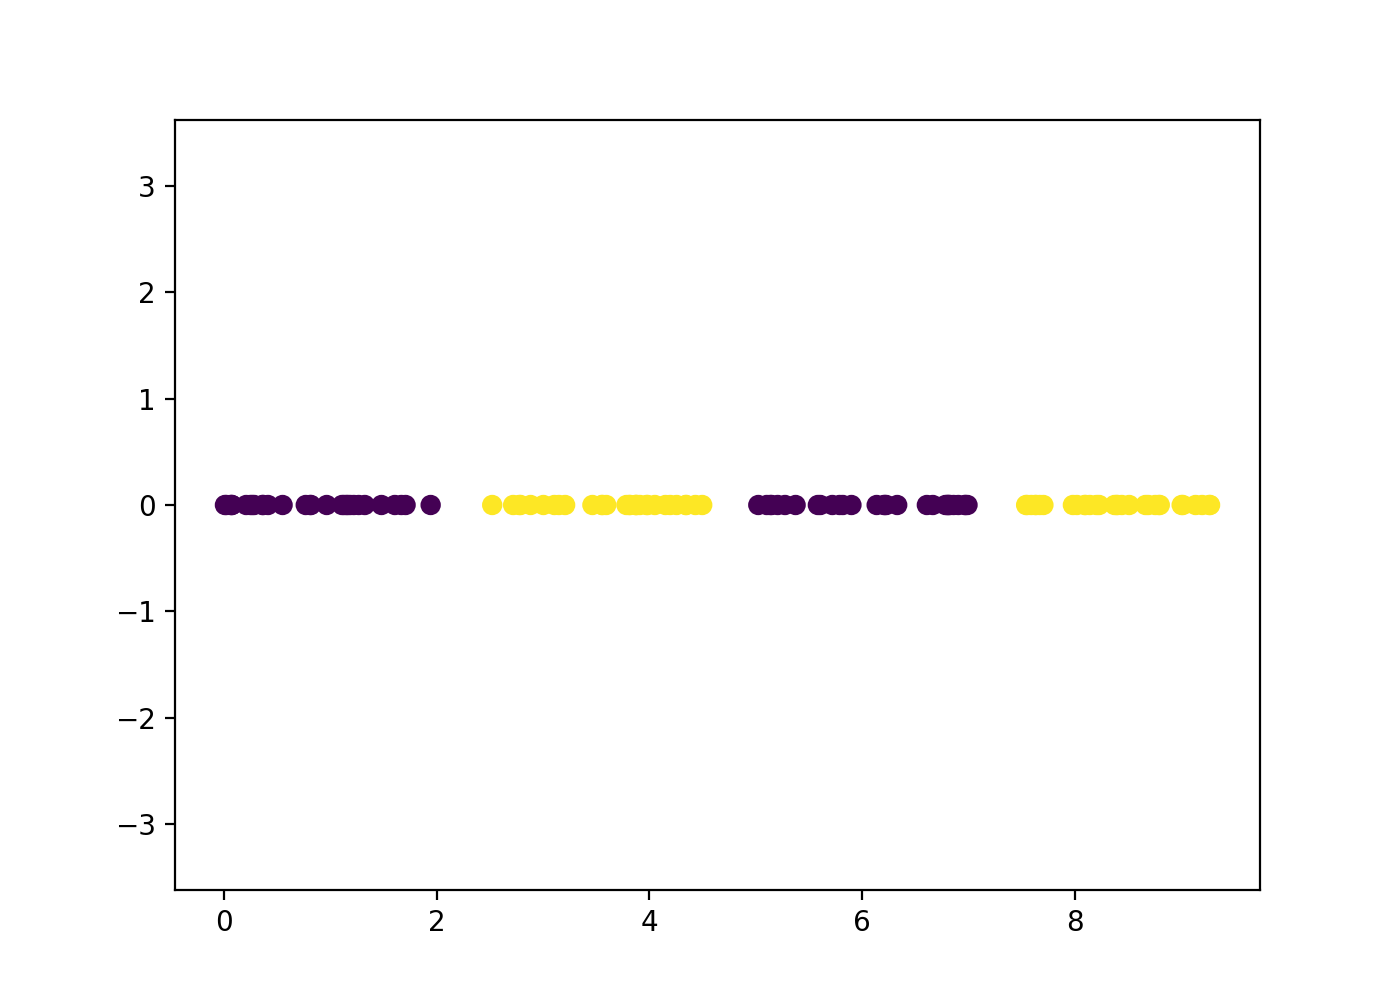

In [164]:
# select the number of subsets and transform the data into tensors
m = 4
data, aux = subsets(m) 
X = torch.from_numpy(data[:,0].reshape(-1, 1)).type(torch.FloatTensor)
y = torch.from_numpy(data[:,1]).type(torch.FloatTensor)
# plot input data
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(data[:,0], aux, c = data[:,1], s=40)
ax.axis('equal')
fig.show()

In [238]:
# define the network object
hidden_dim = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
activation_function = 'tanh'

model = NNClassifier(input_shape=1, hidden_shape=hidden_dim, activation=activation_function).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

criterion = nn.BCELoss()

In [239]:
aux = model.hidden_layer(X).detach().numpy()

In [240]:
# define the training parameters
num_plots = 100
file_name = '1d_2n_train_bce_tanh_{}m'.format(m)
#plot_type = 'surface' # this option is for obtaining a gif with the evolution of the surface
plot_type = '' # this option is for obtaining a gif with the evolution of the hidden space

num_points = 300
x1s = np.linspace(aux[:, 0].min() - 0.5, aux[:, 0].max() + 0.5, num_points)
x2s = np.linspace(aux[:, 1].min() - 0.5, aux[:, 1].max() + 0.5, num_points)
points = np.transpose([np.tile(x1s, len(x2s)), np.repeat(x2s, len(x1s))])
points = torch.from_numpy(points).type(torch.FloatTensor)
X1, X2 = np.meshgrid(x1s, x2s)

kwargs=dict(num_plots=num_plots, points=points, num_points=num_points, file_name=file_name, X1=X1, X2=X2, plot_type=plot_type)

In [241]:
# run the training process
losses = model.train(X, y, 20000, optimizer, criterion, plot=False, **kwargs)
model._hidden_layer.weight

Accuracy: 1.0


Parameter containing:
tensor([[-1.8100],
        [ 3.3615],
        [-6.5073]], requires_grad=True)

<IPython.core.display.Javascript object>


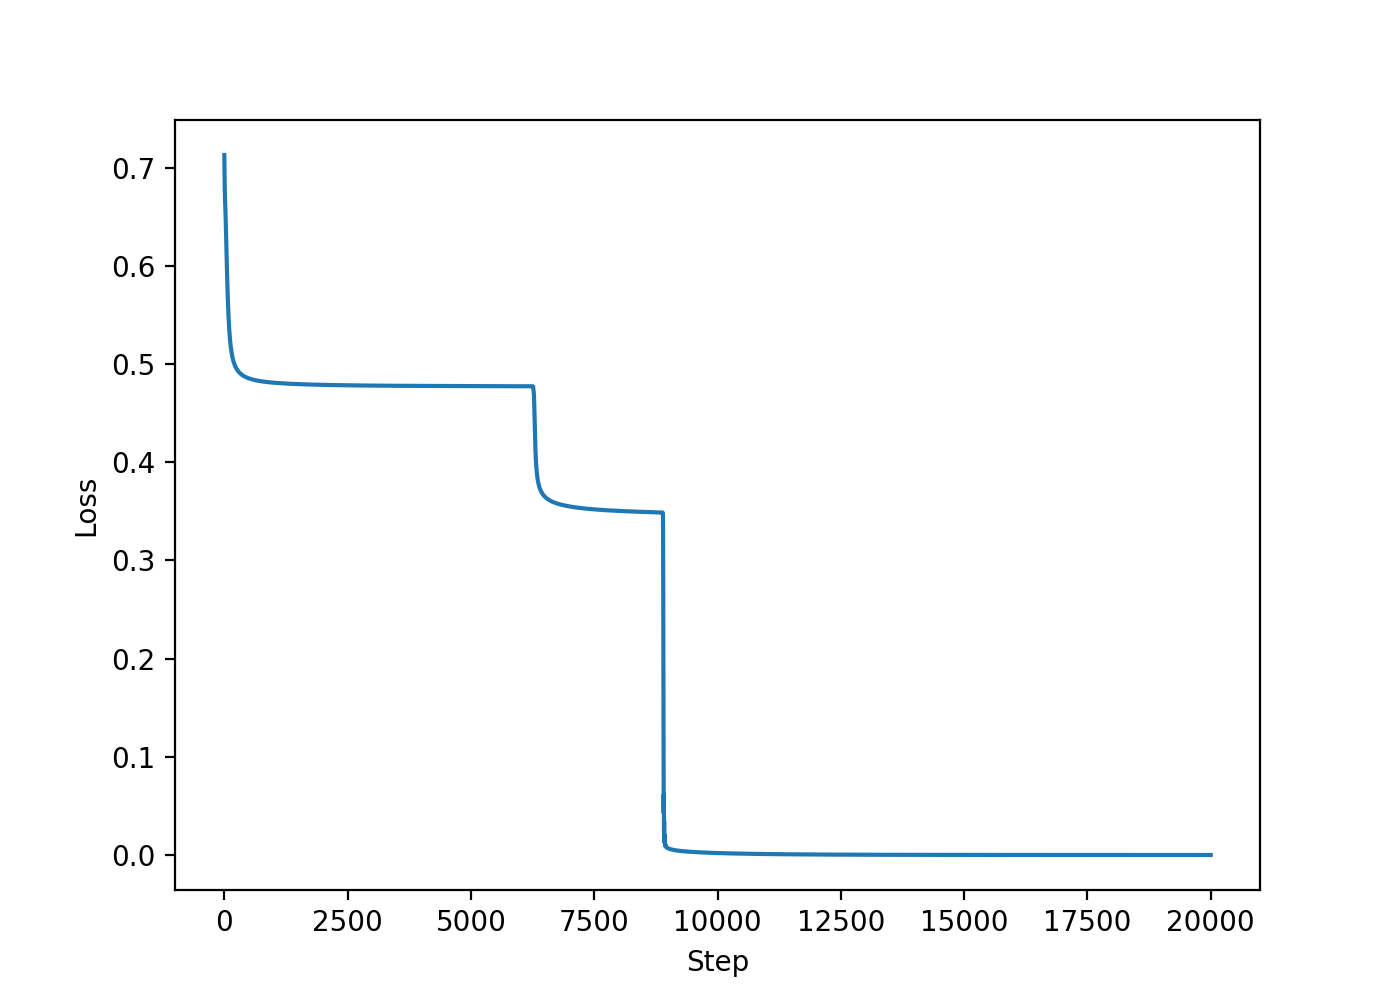

In [242]:
# plot the loss evolution
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(losses)
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
#plt.savefig('segment_{}s_loss_tanh.png'.format(m), dpi=300)
fig.show()

In [ ]:
# obtain the mapped data into the hidden space
H = model.hidden_layer(X)
H = H.detach().numpy()

<IPython.core.display.Javascript object>


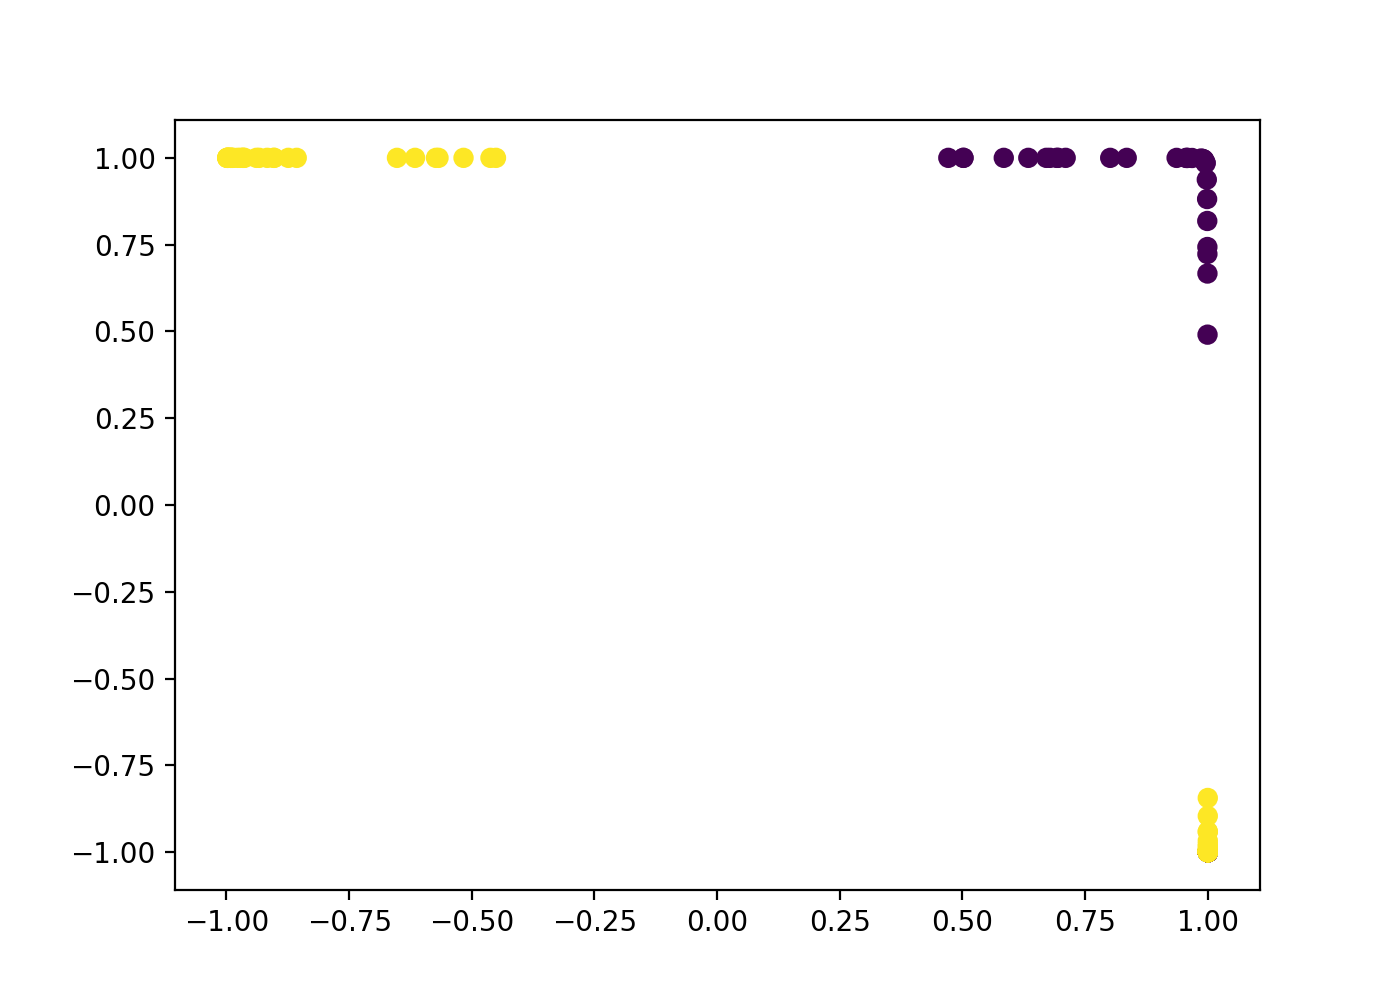

In [244]:
# plot the hidden space in the case of 2D
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(H[:,0],H[:,1],s=40,c=y)
#plt.savefig('segment_{}s_latent_tanh.png'.format(m), dpi=300)
fig.show()

<IPython.core.display.Javascript object>


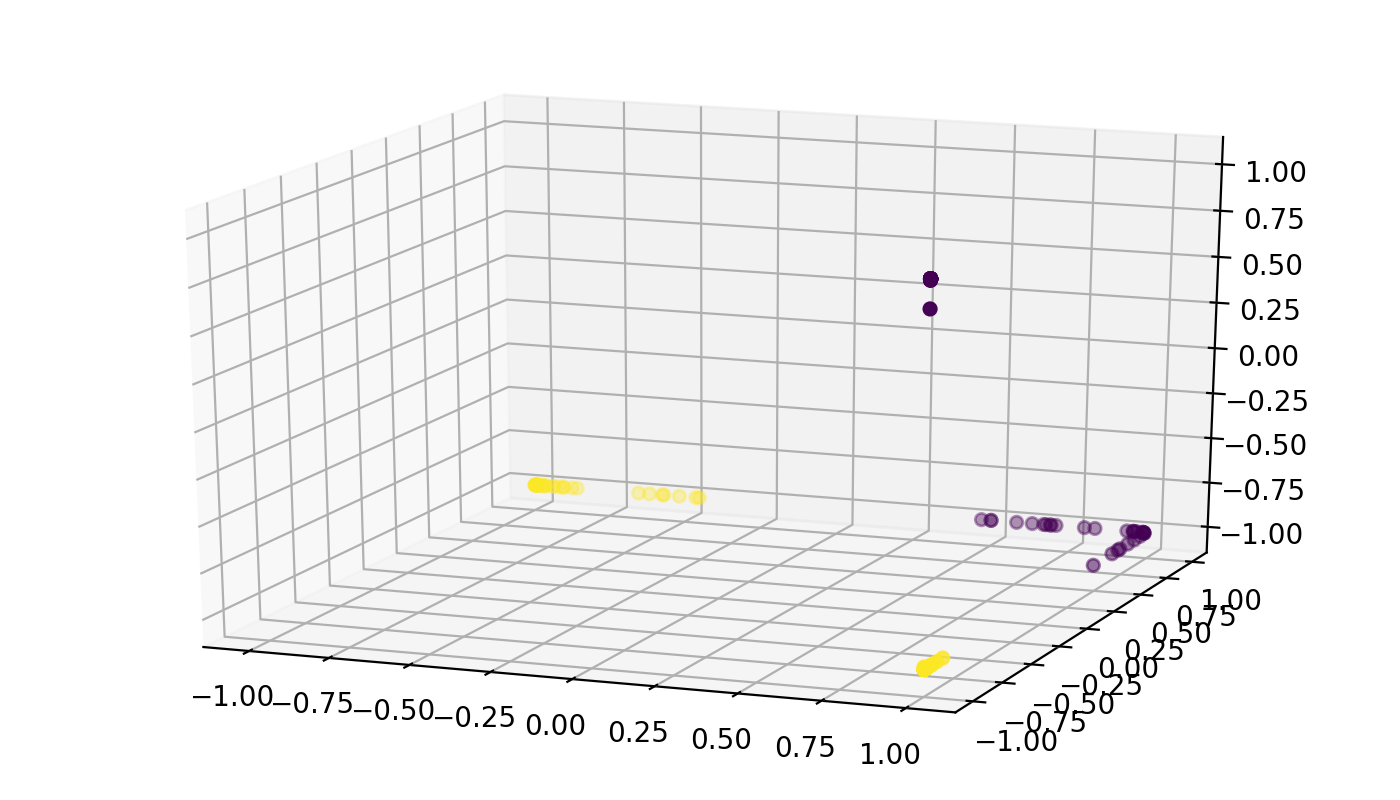

In [248]:
# plot the hidden space in the case of 3D
fig = plt.figure(figsize=(7, 4))
ax = Axes3D(fig)

ax.scatter3D(H[:, 0], H[:, 1], H[:, 2], c=y)
ax.view_init(20, -65)
#plt.savefig('segment_{}s_latent_tanh.png'.format(m), dpi=300)
fig.show()

## Non-injective: sin

<IPython.core.display.Javascript object>


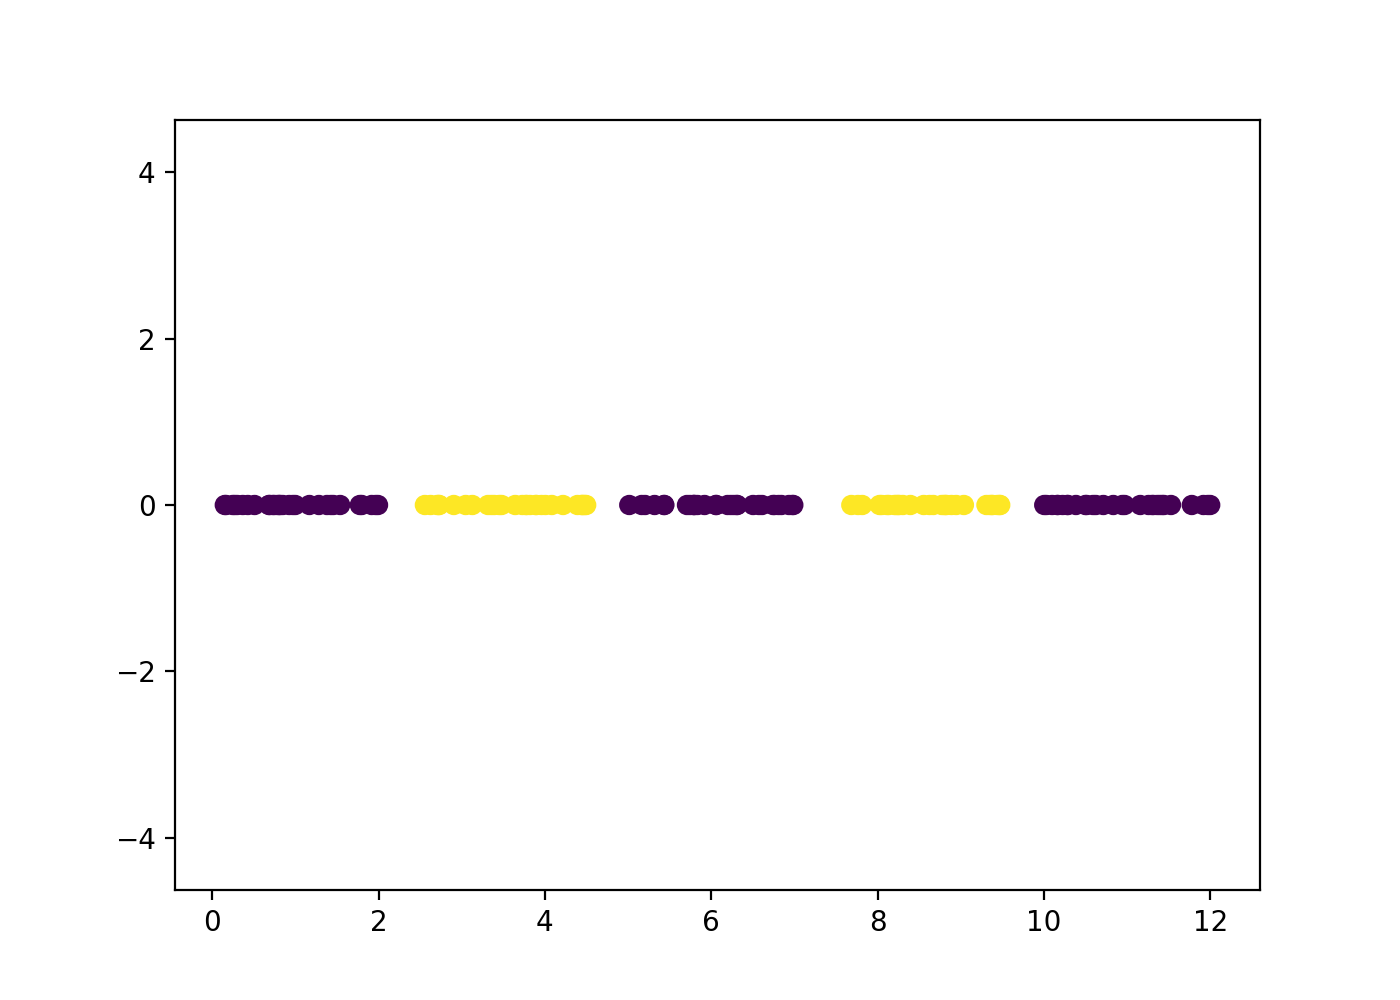

In [5]:
# select the number of subsets and transform the data into tensors
m = 5
data, aux = subsets(m) 
X = torch.from_numpy(data[:,0].reshape(-1, 1)).type(torch.FloatTensor)
y = torch.from_numpy(data[:,1]).type(torch.FloatTensor)
# plot input data
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(data[:,0], aux, c = data[:,1], s=40)
ax.axis('equal')
fig.show()

In [6]:
# define the network object
hidden_dim = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
activation_function = 'sin'

model = NNClassifier(input_shape=1, hidden_shape=hidden_dim, activation=activation_function).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = nn.BCELoss()

In [7]:
aux = model.hidden_layer(X).detach().numpy()

In [8]:
# define the training parameters
num_plots = 100
file_name = '1d_2n_train_bce_sin_{}m'.format(m)
#plot_type = 'surface' # this option is for obtaining a gif with the evolution of the surface
plot_type = '' # this option is for obtaining a gif with the evolution of the hidden space

num_points = 300
x1s = np.linspace(aux[:, 0].min() - 0.5, aux[:, 0].max() + 0.5, num_points)
x2s = np.linspace(aux[:, 1].min() - 0.5, aux[:, 1].max() + 0.5, num_points)
points = np.transpose([np.tile(x1s, len(x2s)), np.repeat(x2s, len(x1s))])
points = torch.from_numpy(points).type(torch.FloatTensor)
X1, X2 = np.meshgrid(x1s, x2s)

kwargs=dict(num_plots=num_plots, points=points, num_points=num_points, file_name=file_name, X1=X1, X2=X2, plot_type=plot_type)

In [9]:
# run the training process
losses = model.train(X, y, 6000, optimizer, criterion, plot=False, **kwargs)
model._hidden_layer.weight

Accuracy: 1.0


Parameter containing:
tensor([[-0.2817],
        [-1.2305]], requires_grad=True)

<IPython.core.display.Javascript object>


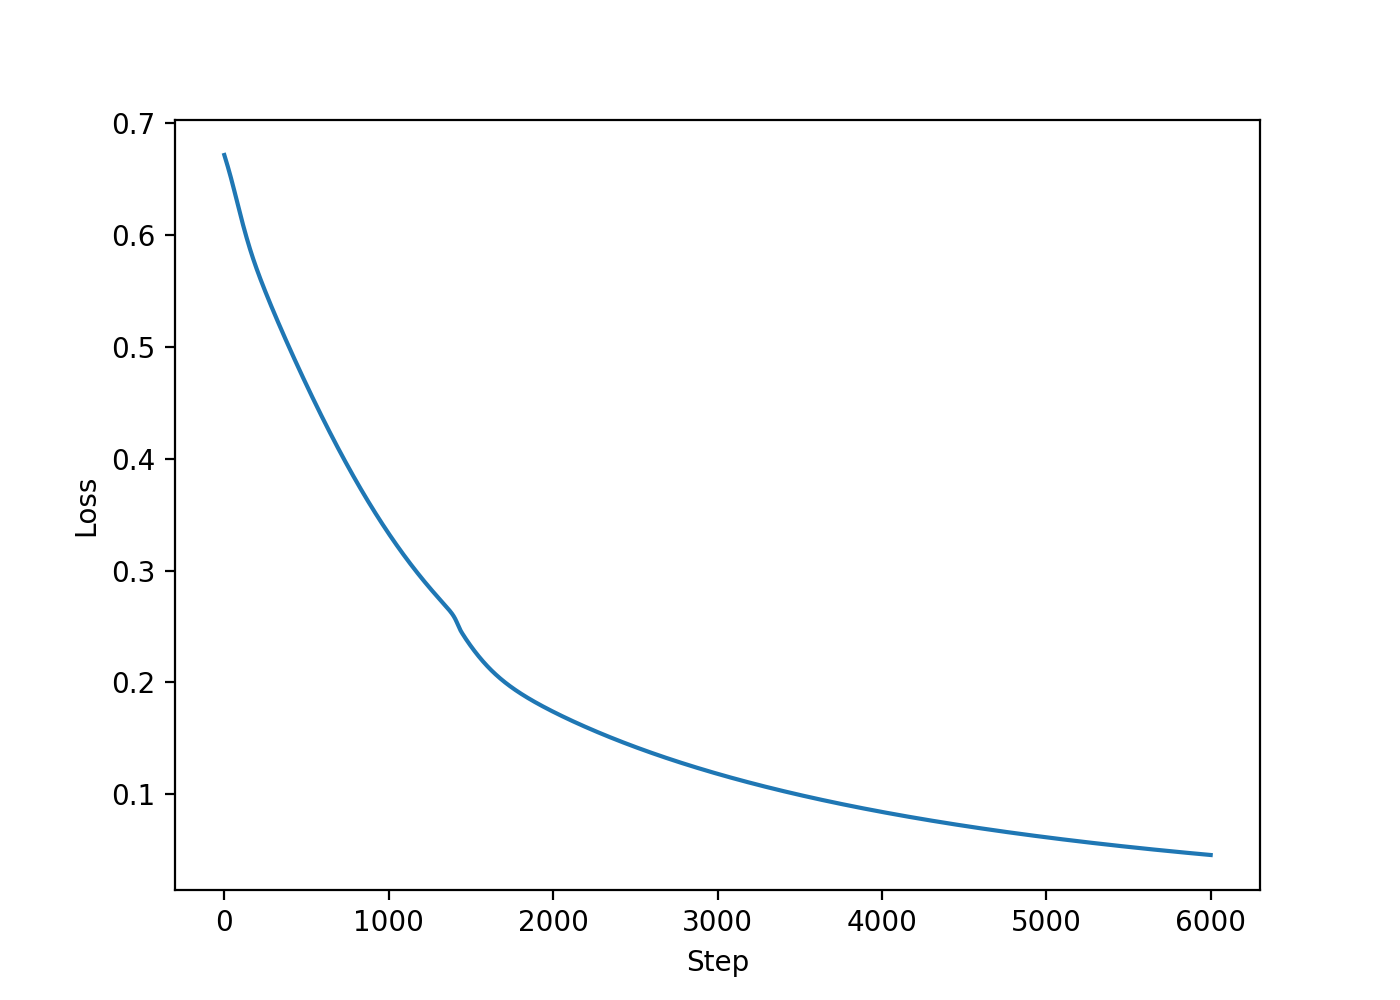

In [10]:
# plot the loss evolution
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(losses)
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
#plt.savefig('segment_{}s_loss_sin_2.png'.format(m), dpi=300)
fig.show()

In [11]:
# obtain the mapped data into the hidden space
H = model.hidden_layer(X)
H = H.detach().numpy()

<IPython.core.display.Javascript object>


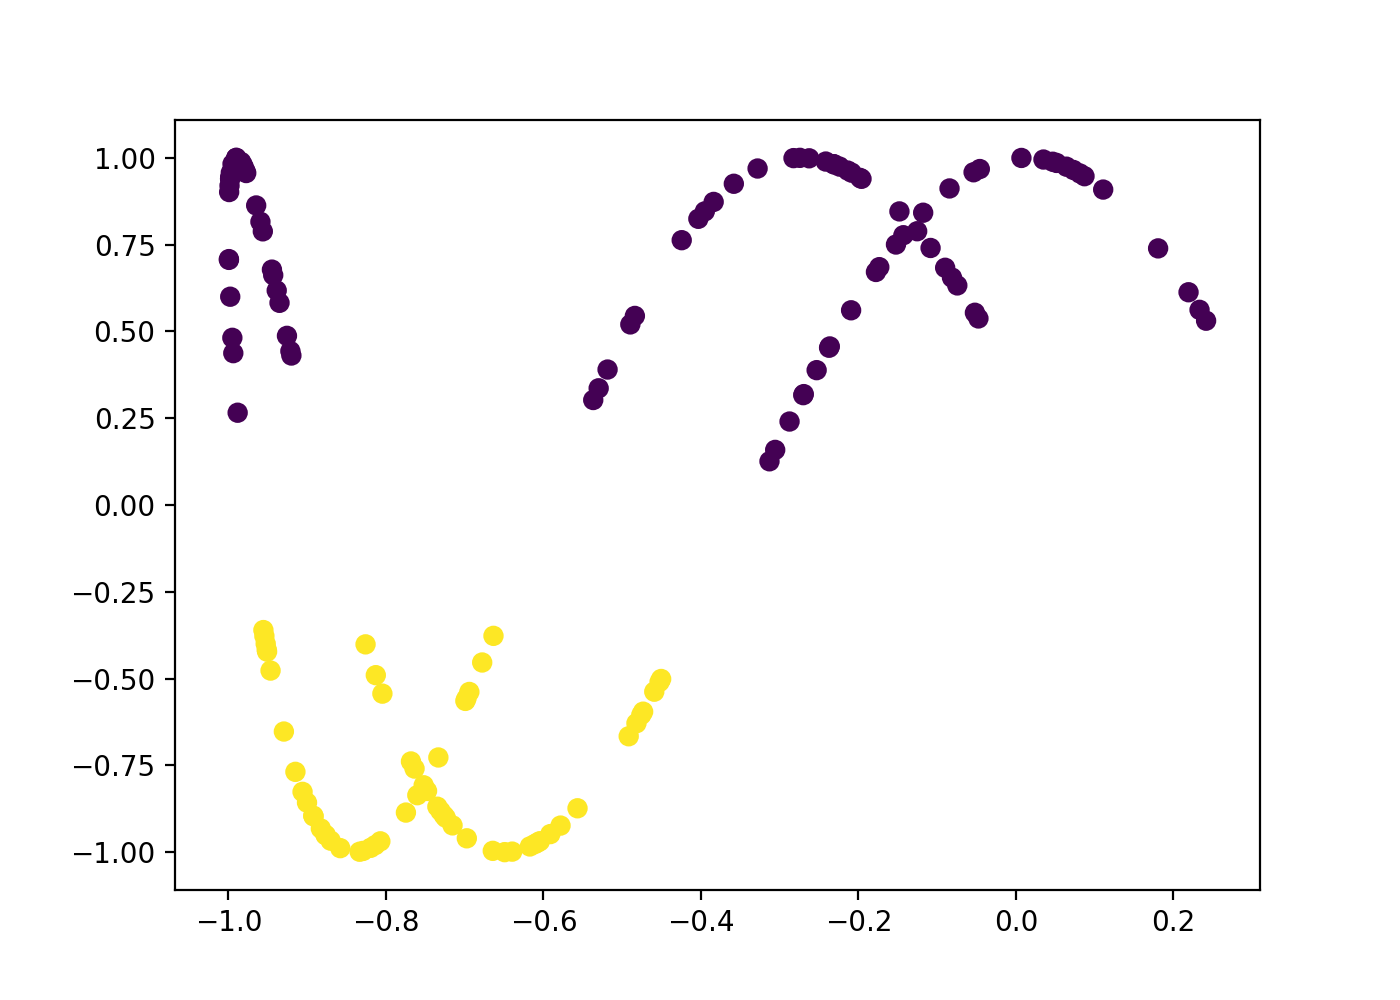

In [12]:
# plot the hidden space
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(H[:,0],H[:,1],s=40,c=y)
#plt.savefig('segment_{}s_latent_sin_2.png'.format(m), dpi=300)
fig.show()